# $$\color{red}{\text{Artificial Intelligence - Camputer Assignment 3}}$$

$$\color{orange}{\text{Naive Bayes Classifier}}$$

$$\color{lime}{\text{Alireza Javid - 810099011}}$$

## $\color{deepskyblue}{\text{Introduction}}$
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
در این تمرین با استفاده از روش  Naive Bayes Classifier سعی در طبقه بندی یک دیتاست با داده های train داریم و در نهایت می خواهیم داده های test را به کمک برنامه نوشته شده به درستی طبقه بندی کنیم.
</font>
</p>

## $\color{deepskyblue}{\text{Import Libraries}}$

In [1]:
from __future__ import unicode_literals
from hazm import *
import arabic_reshaper
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import operator
from sklearn.metrics import classification_report

## $\color{deepskyblue}{\text{Preprocessing}}$

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...


In [3]:
train_df["label"].unique()

array(['فناوری', 'ورزشی', 'حوادث', 'سلامت', 'سیاسی', 'فرهنگی/هنری'],
      dtype=object)

In [4]:
test_df = pd.read_csv('test.csv')
test_df.head()

,label,content
0,فناوری,بعد از اعلام لیست ۲۳ شرکت مجاز ثبت سفارش و ارا...
1,فرهنگی/هنری,یک استاد علم قرائت قرآن کریم، گفت: ریشه موسیقی...
2,حوادث,آتش سوزی های زنجیره ای جنگل های زاگرس در استان...
3,فناوری,استفاده از سرویس‌های iMassage یا Facetime محصو...
4,حوادث,دادستان عمومی و انقلاب یاسوج گفت: 10 میلیون دل...


### $\color{deepskyblue}{\text{Question 1}}$
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
در ابتدا سعی در پردازش داده و ساده تر کردن حجم بالای داده های موجود می باشد. 
در یک متن ممکن است به دلایل قواعد زبان اشکال متفاوت یک کلمه استفاده شود. همچنین ممکن است که کلماتی با شباهت معنایی بالا در یک متن بکار روند.
به کمک توابع موجود در کتابخانه hazm متن را پردازش می کنیم.
در اینجا ابتدا متن را نرمالایز می‌کنیم (نیم فاصله ها را به متن اضافه می‌کنیم) و سپس  کلمات متن را جدا می‌کنیم و ایست‌واژه‌ها، اعداد و کلمات پرتکرار بی‌اهمیت که با stopwords_list در کتابخانه hazm وجود دارد را حذف می کنیم. سپس به کمک lemmatisation کلمات مشابه مانند کلمات هم‌خانواده و هم معنی را در یک گروه قرار می‌دهیم و یک کلمه در نظر می‌گیریم. روش stemming نیز کلمات را به ریشه آنها باز می گرداند تا در پردازش بهتر عمل کنند.
</font>
</p>

In [5]:
lemmatizer = Lemmatizer()
normalizer = Normalizer()

def preprocess_text(text):
    text = ''.join([i for i in text if not i.isdigit()]) 
    text = normalizer.normalize(text)
    tokens = word_tokenize(text)
    stop_words = stopwords_list()
    stop_words = stop_words + ['میشود', 'میکند', 'میتواند', 'نفر']
    stop_words = set(stop_words)
    punctuation = set('''?\#$%@&^.؟؛][=*×،!-+ـ)(٪:«»<>…/_.,{};~'"|٬٫''')
    whitespace = {"\n" , "\r" , "\t", "\u200c"}
    chosen_tokens = []
    for token in tokens:
        if token not in stop_words and token not in punctuation and token not in whitespace:
            chosen_tokens.append(lemmatizer.lemmatize(token).split('#')[0])
    return chosen_tokens

test_df["row_content"] = test_df["content"]
train_df["content"].fillna("",inplace=True)
train_df["label"].fillna("",inplace=True)
test_df["content"].fillna("",inplace=True)
test_df["label"].fillna("",inplace=True)
train_df["content"] = train_df["content"].apply(preprocess_text)
test_df["content"] = test_df["content"].apply(preprocess_text)

### $\color{deepskyblue}{\text{Question 2}}$
![alt text](Capture.png "Title")
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
x: مجموعه کلمات دیده شده.
<br>
c: موضوع خبر 
<br>
P(C|X) (Posterior Probability)  : احتمال اینکه موضوع خبر c باشد به شرط اینکه x در آن دیده شود.
<br>
روش محاسبه: این احتمال با استفاده از سه متغیر دیگر محاسبه می‌شود. 
<br>
P(X|C) (Likelihood)  : احتمال اینکه x دیده شود، به شرط اینکه موضوع خبر c باشد. 
<br>
روش محاسبه: به ازای هر موضوع y دیده شده باید تکرار یک کلمه x را در آن موضوع را بدست آوریم و در نهایت هنگامی که این احتمال را برای تمامی کلمات حساب کنیم می توانیم این احتمال را بدست آوریم. 
<br>
P(C) (Class Prior Probablity)  : احتمال مشاهده یک موضوع در ابتدا بدون دانش قبلی.
<br>
روش محاسبه: کافی است تعداد خبر های مربوط به هر موضوع را پیدا کرده و بر تعداد کل خبر ها تقسیم کنیم.. 
<br>
P(X) (Predictor Prior Probablity)  : احتمال مشاهده یک کلمه در ابتدا و بدون دانش قبلی.
<br>
روش محاسبه: کافی است تعداد تکرار یک مجموعه کلمه مشخص x را به ازای تمامی خبر های موجود پیدا کرده و بر کل آنها تقسیم می کنیم.
</font>
</p>

<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
حالا متناسب با label داده های پس از پیش پردازش آن ها را طبقه بندی می کنیم و مدل train را تشکیل می دهیم..
</font>
</p>

In [6]:
def count_train_info(trainInfo , words , category):
    for word in words:
        all_categories_words.add(word)
        train_counts[category] += 1
        if(word in train_info[category].keys()):
            train_info[category][word] += 1
        else:
            train_info[category][word] = 1
            
train_counts = {"فناوری": 0 , "فرهنگی/هنری": 0 , "حوادث": 0 , "ورزشی": 0, "سلامت":0, "سیاسی":0}
train_info = {"فناوری": {} , "فرهنگی/هنری": {} , "حوادث": {} , "ورزشی": {}, "سلامت":{}, "سیاسی":{}}
all_categories_words = set()
train_df.apply(lambda row : count_train_info(train_info , row["content"] , row["label"]), axis = 1);

### $\color{deepskyblue}{\text{Question 3}}$
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
جملات زیر را در نظر بگیرید:
<br>
- علی یک پاکت شیر خورد.
<br>
- حسین شیر دستشویی را باز کرد.
<br>
- احمد در جنگل یک شیر را دید.
<br>
همانطور که مشخص است در سه جمله بالا کلمه "شیر" با سه معنی متفاوت به کار رفته است. اگر از bigram استفاده کنیم در جمله اول با توجه به کلمه "پاکت" و "شیر", در جمله دوم به کمک "دستشویی" و "شیر"  و در جمله سوم به کمک "جنگل" و "شیر" می توان معنی شیر را در هر جمله تشخیص داد و طبقه بندی را بهبود داد. همانطور که دیده شد استفاده از bigram در این مثال کافی می باشد. 
<br>
در این پروژه از unigram استفاده کرده و به بافت جملات توجه نمی کنیم.
</font>
</p>



### $\color{deepskyblue}{\text{Question 4}}$
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
اگر به رابطه بیز که در بالا آمده است دقت کنید, اگر کلمه x تنها در کلاس c باشد مقدار مقدار احتمال P(C|X) به صورت قطعی مشخص می شود زیرا با مشاهده کلمه x تنها کلاس c 
در واقع می توان گفت برای کلاس های دیگر P(X|C) شامل کلمه مورد نظر x نمی باشد و P(C|X=x) برای این کلاس ها صفر خواهد بود.
</font>
</p>

### $\color{deepskyblue}{\text{Question 5}}$
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
این روش برای smooth کردن داده های طبقه بندی شده به کار می رود. در این روش ما از احتمال صفر جلوگیری می کنیم. در این روش یک مقدار کوچک تصحیح به احتمال اضافه می شود و در نتیجه آن هیچ احتمالی برابر صفر نخواهد بود و از آنجایی که در داده تست ممکن است کلماتی وجود داشته باشد که در داده تست نباشند این شیوه می تواند بسیار نتایج بهتری به ما دهد. در واقع با این روش سعی می کنیم Naive Bayes را منظم و بهتر کنیم.
</font>
</p>

$$
P(X|C) = \frac{x + \alpha}{N + \alpha D}
$$
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
در رابطه بالا آلفا یک ثابت بین 0 و 1 است. N بیانگر کل کلمات مجموعه می باشد و D تعداد کلمات یکتا در تمامی کلاس ها می باشد. در کد زیر برای سادگی بیشتر به جای ضرب عبارات، لگاریتم آن ها را جمع می‌کنیم. </font>
</p>

In [7]:
def additive_smoothing(train_info , train_counts , test_words, alpha):
    title = ""
    p_max = float("-inf"); 
    for category , words in train_info.items():
        p = math.log(1/5)  
        for test_word in test_words:
            if(test_word not in words.keys()):
                if not alpha:
                    p += float("-inf")
                else:
                    p += math.log(alpha / (train_counts[category] + alpha * len(all_categories_words) ) )
            else:
                p += math.log((words[test_word] + alpha) / (train_counts[category] + alpha * len(all_categories_words)))
        if(p_max < p ):
            title = category
            p_max = p  
    return title

alpha = 0.35
test_df["additive_smoothing_results"] = test_df.apply(lambda row : additive_smoothing(train_info , train_counts , row["content"], alpha) , axis = 1)
test_df["additive_smoothing_validity"] = np.where(test_df["label"] == test_df["additive_smoothing_results"], True, False)
test_df["additive_smoothing_validity"].value_counts()
AD_accuracy = test_df[test_df["additive_smoothing_validity"]]["additive_smoothing_validity"].count() / test_df["additive_smoothing_validity"].count()

test_df["bayes_results"] = test_df.apply(lambda row : additive_smoothing(train_info , train_counts , row["content"], 0) , axis = 1)
test_df["bayes_results_validity"] = np.where(test_df["label"] == test_df["bayes_results"], True, False)
test_df["bayes_results_validity"].value_counts()
B_accuracy = test_df[test_df["bayes_results_validity"]]["bayes_results_validity"].count() / test_df["bayes_results_validity"].count()

print("Accuracy with additive smoothing is " + str(AD_accuracy))
print("Accuracy without additive smoothing is " + str(B_accuracy))

Accuracy with additive smoothing is 0.9408071748878923
Accuracy without additive smoothing is 0.18565022421524663


### $\color{deepskyblue}{\text{Question 6}}$

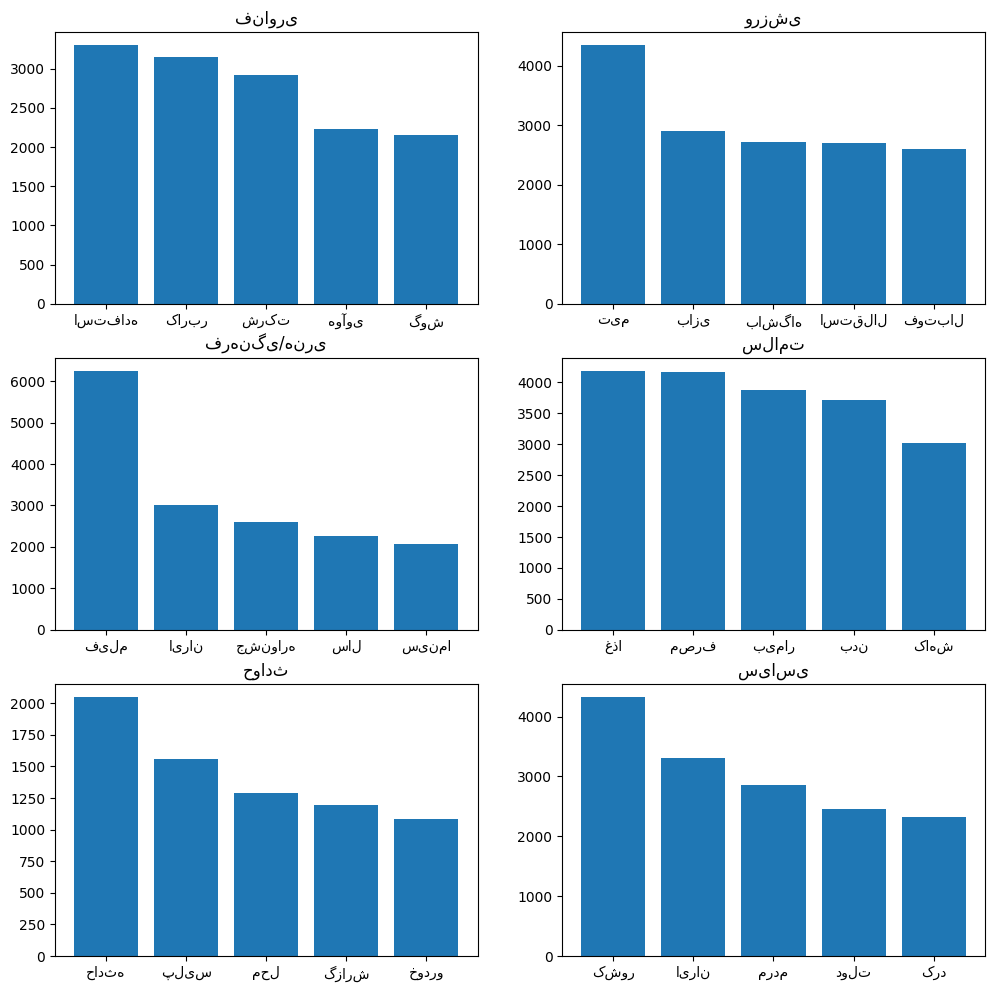

In [8]:
fig, axes = plt.subplots(3,2,figsize=(12,12))
i, j = 0, 0
for category in train_info.keys():
    train_info_with_sort = dict(sorted(train_info[category].items(), key=operator.itemgetter(1), reverse=True)[:5])
    words = [word for word in train_info_with_sort.keys()]
    numbers = [num for num in train_info_with_sort.values()]
    axes[i][j].bar(words , numbers)
    axes[i][j].set_title(category)
    i += 1
    if i==3:
        i = 0
        j += 1
plt.show()

### $\color{deepskyblue}{\text{Question 7}}$ 
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
در معیار 𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 ما تنها تعداد خبر های تشخیص داده شده را در مخرج قرار می دهیم و می تواند نتیجه نادرستی به ما بدهد. مثلا فرض کنید که از بین 100 خبر موجود تنها 10 تا از آنها تشخیص داده شده و آن ها نیز درست بوده است. در این حالت 𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 برابر 1 خواهد بود اما 90 درصد اخبار حتی تشخیص نیز داده نشده است. در این معیار به دقت پیش بینی پرداخته می شود و پیش بینی های اشتباه نادرست بررسی نمی شود.
<br>
معیار 𝑅𝑒𝑐𝑎𝑙𝑙 به کامل بودن پیش بینی دلالت دارد. در این معیار پیش بینی های صحیح درست را از میان صحیح های درست و اشتباه های نادرست بدست می آورد و به پیش بینی های صحیح نادرست توجه نمی کند. مثلا فرض کنید تمام اخبار ورزشی تشخیص داده شود در این صورت این معیار برابر 1 خواهد بود اما می دانیم که این پیش بینی مناسب نخواهد بود.
</font>
</p>

### $\color{deepskyblue}{\text{Question 8}}$ 
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
معیار F1 به نوعی harmonic mean بین Precision و Recall می باشد. این میانگین معمولاً هنگامی کاربرد دارد که محاسبه میانگین نرخ‌ها اهمیت داشته باشد. در موارد خاص که فقط دو عدد وجود دارد، میانگین هارمونیک را می‌توان از رابطه معیار اف-۱ به دست آورد. می‌توان ثابت کرد که میانگین هم‌ساز همواره کوچک‌تر یا مساوی میانگین حسابی است. همچنین، از این میانگین تنها برای اعداد مثبت استفاده می‌شود. فرض کنید یکی از Precision یا Recall برابر 0 باشد و دیگری 100. میانگین عادی عدد 50 را بدست می دهد درحالی که میانگین هارمونیک عدد بهتری را به ما می دهد.
</font>
</p>

### $\color{deepskyblue}{\text{Question 9}}$ 
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    Macro:
        میانگین حسابی مقادیر اف-۱ کلاس‌ها
        <br>
    Micro:
        برابر با همان دقت است یعنی تعداد طبقه‌بندی‌های درست تقسیم بر تعداد کل نمونه‌ها
        <br>
    Weighted:
        میانگین وزن‌دار مقادیر اف-۱ کلاس‌ها که در آن وزن هر مقدار را می‌توان نسبت تعداد نمونه‌های آن کلاس به تعداد کل نمونه‌ها در نظر گرفت
</font>
</p>

### $\color{deepskyblue}{\text{Question 10}}$ 
#### $\color{deepskyblue}{\text{Part A: Without Additive Smoothing}}$ 

*** حوادث ***
Precision: 0.8611111111111112%  
Recall: 0.155%  
F1: 0.2627118644067797% 

*** فناوری ***
Precision: 0.72%  
Recall: 0.10714285714285714%  
F1: 0.18652849740932642% 

*** سلامت ***
Precision: 0.96%  
Recall: 0.13559322033898305%  
F1: 0.2376237623762376% 

*** فرهنگی/هنری ***
Precision: 0.8125%  
Recall: 0.21666666666666667%  
F1: 0.34210526315789475% 

*** ورزشی ***
Precision: 0.9565217391304348%  
Recall: 0.23157894736842105%  
F1: 0.3728813559322034% 

*** سیاسی ***
Precision: 0.8360655737704918%  
Recall: 0.255%  
F1: 0.3908045977011494% 

Accuracy: 18.565022421524663%
False    908
True     207
Name: bayes_results_validity, dtype: int64


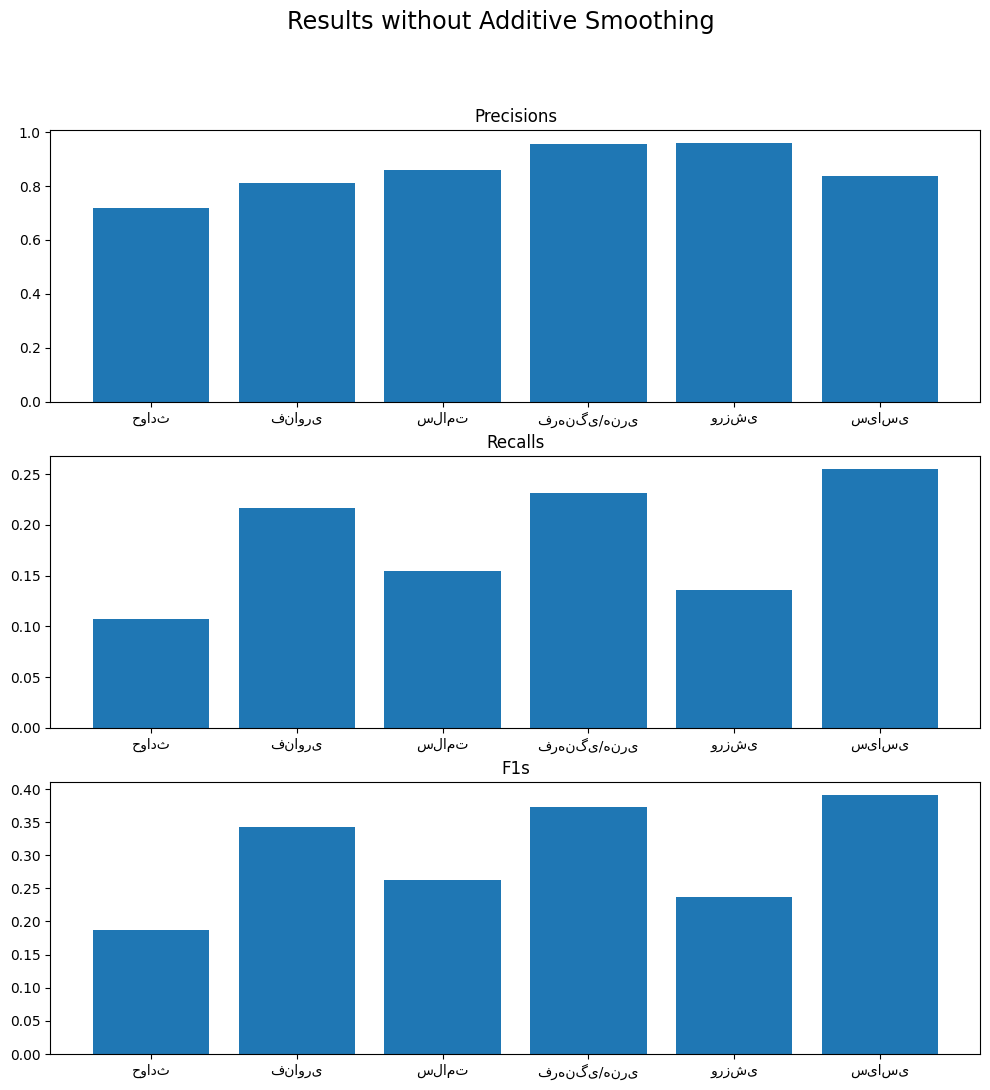

In [9]:
precisions =  {"فناوری": 0 , "فرهنگی/هنری": 0 , "حوادث": 0 , "ورزشی": 0, "سلامت":0, "سیاسی":0}
recalls =  {"فناوری": 0 , "فرهنگی/هنری": 0 , "حوادث": 0 , "ورزشی": 0, "سلامت":0, "سیاسی":0}
F1s =  {"فناوری": 0 , "فرهنگی/هنری": 0 , "حوادث": 0 , "ورزشی": 0, "سلامت":0, "سیاسی":0}
class_count =  {"فناوری": 0 , "فرهنگی/هنری": 0 , "حوادث": 0 , "ورزشی": 0, "سلامت":0, "سیاسی":0}
categories= set(test_df["label"])

for category in categories:
    currect_predict = 0
    total_predict = 0
    for i in range(len(test_df)):
        if  test_df.loc[i, "bayes_results"] == category:
            total_predict += 1
        if test_df.loc[i, "label"] == category:
            class_count[category] += 1
            if test_df.loc[i, "bayes_results_validity"] == True:
                currect_predict += 1
    precisions[category] = currect_predict / total_predict
    recalls[category] = currect_predict / class_count[category]
    F1s[category] = 2 * (precisions[category]*recalls[category]) / (precisions[category]+recalls[category])

    
for category in categories:
    print("*** " + category + " ***")
    print("Precision: " + str(precisions[category]) + "%  \nRecall: " + str(recalls[category]) + \
          "%  \nF1: " + str(F1s[category]) + "% \n")

print("Accuracy: " + str(B_accuracy * 100) + "%")
print(test_df["bayes_results_validity"].value_counts())
categories = list(categories)
fig, axes = plt.subplots(3,1,figsize=(12,12))
fig.suptitle("Results without Additive Smoothing",fontsize='xx-large');
axes[0].set_title("Precisions")
numbers = list(precisions.values())
axes[0].bar(categories , numbers)


axes[1].set_title("Recalls")
numbers = list(recalls.values())
axes[1].bar(categories , numbers)


axes[2].set_title("F1s")
numbers = list(F1s.values())
axes[2].bar(categories , numbers)

plt.show()

Macro Average Precision: 0.8576997373353397%
Macro Average Recall: 0.18349694858615465%
Macro Average F1: 0.29877589016393186%


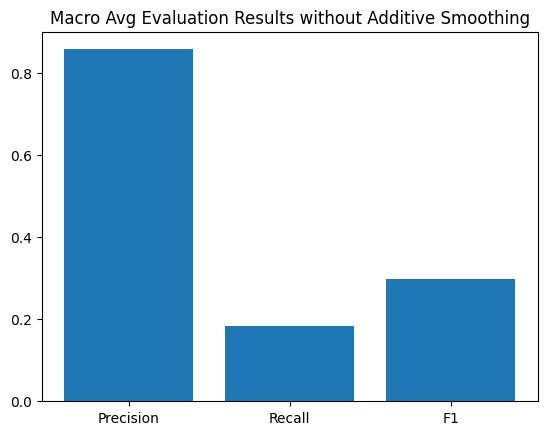

In [10]:
macro_precision = sum(precisions.values()) / len(categories)
macro_recall = sum(recalls.values()) / len(categories)
macro_F1 = sum(F1s.values()) / len(categories)
print("Macro Average Precision: " + str(macro_precision) + "%")
print("Macro Average Recall: " + str(macro_recall) + "%")
print("Macro Average F1: " + str(macro_F1) + "%")
fig, ax = plt.subplots()
ax.set_title("Macro Avg Evaluation Results without Additive Smoothing")
words = ["Precision" , "Recall" , "F1"]
numbers = [macro_precision , macro_recall , macro_F1]
ax.bar(words , numbers)
plt.show()

Weighted Average Precision: 0.859465890054801%
Weighted Average Recall: 0.18565022421524663%
Weighted Average F1: 0.3018169425313779%


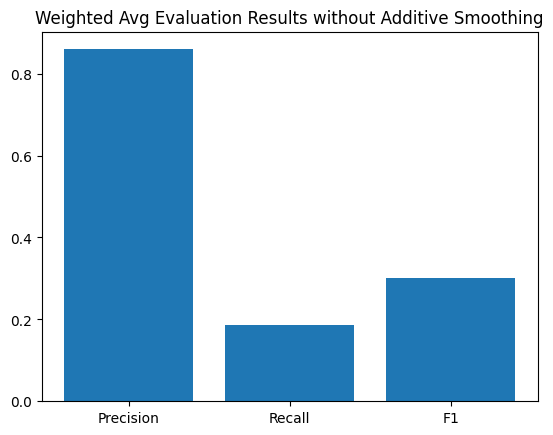

In [11]:
weighted_precision = 0; weighted_recall = 0; weighted_F1 = 0
for category in categories:
    weighted_precision += (class_count[category] * precisions[category])
    weighted_recall += (class_count[category] * recalls[category])
    weighted_F1 += (class_count[category] * F1s[category]) 
weighted_precision /= len(test_df)
weighted_recall /= len(test_df)
weighted_F1 /= len(test_df)
print("Weighted Average Precision: " + str(weighted_precision) + "%")
print("Weighted Average Recall: " + str(weighted_recall) + "%")
print("Weighted Average F1: " + str(weighted_F1) + "%")
fig, ax = plt.subplots()
ax.set_title("Weighted Avg Evaluation Results without Additive Smoothing")
words = ["Precision" , "Recall" , "F1"]
numbers = [weighted_precision , weighted_recall , weighted_F1]
ax.bar(words , numbers)
plt.show()

In [12]:
accuracy = str(B_accuracy * 100)
print("Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = " + accuracy + "%")

Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = 18.565022421524663%


#### $\color{deepskyblue}{\text{Part B: With Additive Smoothing}}$ 

*** حوادث ***
Precision: 0.9061032863849765%  
Recall: 0.965%  
F1: 0.9346246973365617% 

*** فناوری ***
Precision: 0.9627329192546584%  
Recall: 0.9226190476190477%  
F1: 0.9422492401215807% 

*** سلامت ***
Precision: 0.9709302325581395%  
Recall: 0.943502824858757%  
F1: 0.9570200573065902% 

*** فرهنگی/هنری ***
Precision: 0.9470588235294117%  
Recall: 0.8944444444444445%  
F1: 0.9199999999999999% 

*** ورزشی ***
Precision: 0.9891891891891892%  
Recall: 0.9631578947368421%  
F1: 0.976% 

*** سیاسی ***
Precision: 0.8878504672897196%  
Recall: 0.95%  
F1: 0.9178743961352657% 

Accuracy: 94.08071748878923%
True     1049
False      66
Name: additive_smoothing_validity, dtype: int64


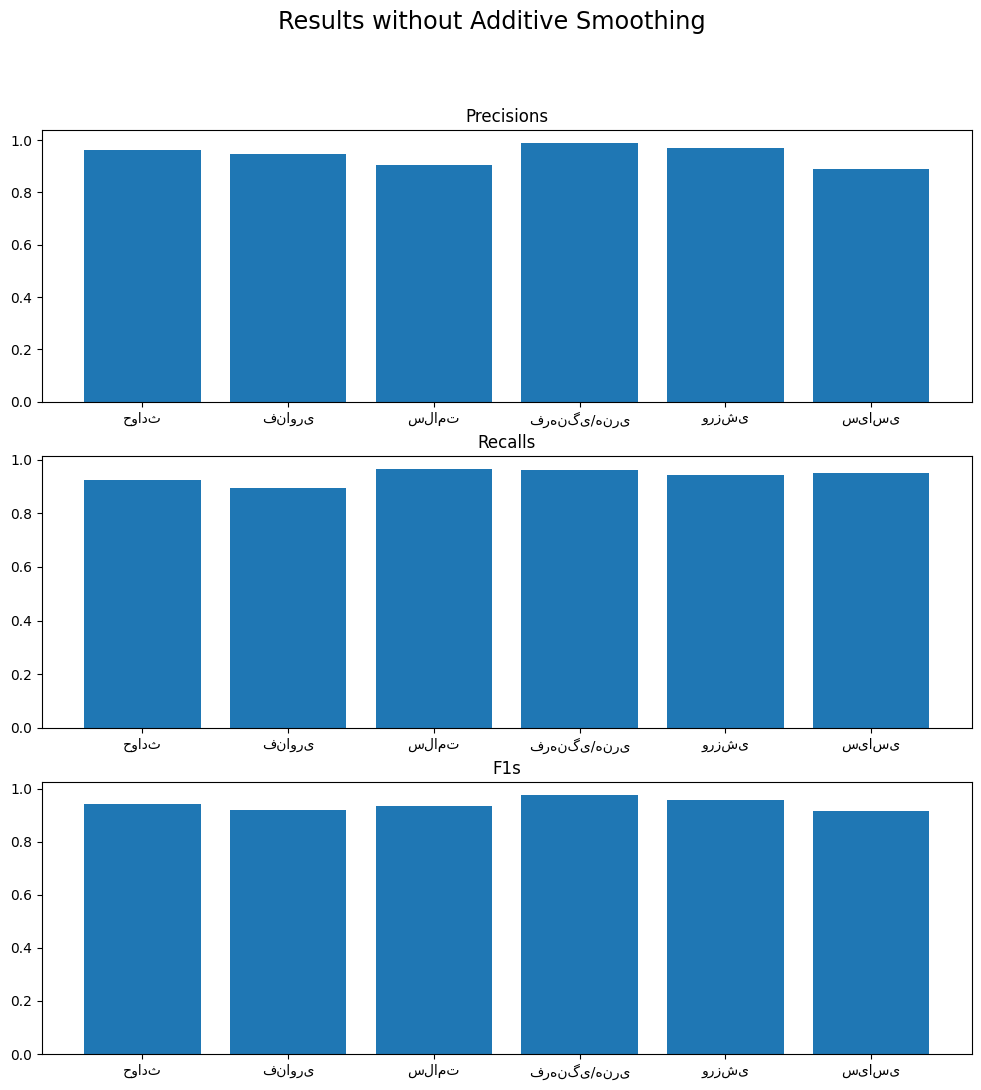

In [13]:
precisions =  {"فناوری": 0 , "فرهنگی/هنری": 0 , "حوادث": 0 , "ورزشی": 0, "سلامت":0, "سیاسی":0}
recalls =  {"فناوری": 0 , "فرهنگی/هنری": 0 , "حوادث": 0 , "ورزشی": 0, "سلامت":0, "سیاسی":0}
F1s =  {"فناوری": 0 , "فرهنگی/هنری": 0 , "حوادث": 0 , "ورزشی": 0, "سلامت":0, "سیاسی":0}
class_count =  {"فناوری": 0 , "فرهنگی/هنری": 0 , "حوادث": 0 , "ورزشی": 0, "سلامت":0, "سیاسی":0}
categories= set(test_df["label"])

for category in categories:
    currect_predict = 0
    total_predict = 0
    for i in range(len(test_df)):
        if  test_df.loc[i, "additive_smoothing_results"] == category:
            total_predict += 1
        if test_df.loc[i, "label"] == category:
            class_count[category] += 1
            if test_df.loc[i, "additive_smoothing_validity"] == True:
                currect_predict += 1
    precisions[category] = currect_predict / total_predict
    recalls[category] = currect_predict / class_count[category]
    F1s[category] = 2 * (precisions[category]*recalls[category]) / (precisions[category]+recalls[category])

    
for category in categories:
    print("*** " + category + " ***")
    print("Precision: " + str(precisions[category]) + "%  \nRecall: " + str(recalls[category]) + \
          "%  \nF1: " + str(F1s[category]) + "% \n")

print("Accuracy: " + str(AD_accuracy * 100) + "%")
print(test_df["additive_smoothing_validity"].value_counts())
categories = list(categories)
fig, axes = plt.subplots(3,1,figsize=(12,12))
fig.suptitle("Results without Additive Smoothing",fontsize='xx-large');
axes[0].set_title("Precisions")
numbers = list(precisions.values())
axes[0].bar(categories , numbers)


axes[1].set_title("Recalls")
numbers = list(recalls.values())
axes[1].bar(categories , numbers)


axes[2].set_title("F1s")
numbers = list(F1s.values())
axes[2].bar(categories , numbers)

plt.show()

Macro Average Precision: 0.9439774863676824%
Macro Average Recall: 0.9397873686098487%
Macro Average F1: 0.9412947318166663%


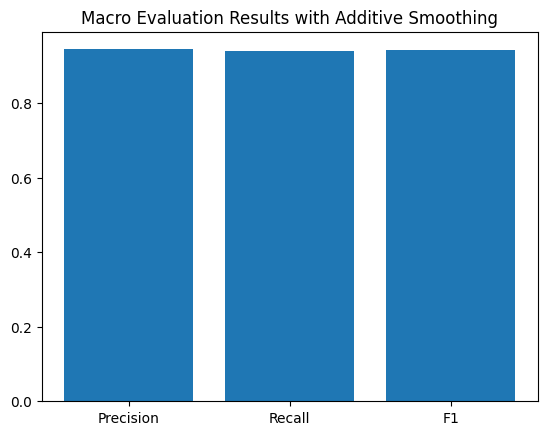

In [14]:
macro_precision = sum(precisions.values()) / len(categories)
macro_recall = sum(recalls.values()) / len(categories)
macro_F1 = sum(F1s.values()) / len(categories)
print("Macro Average Precision: " + str(macro_precision) + "%")
print("Macro Average Recall: " + str(macro_recall) + "%")
print("Macro Average F1: " + str(macro_F1) + "%")
fig, ax = plt.subplots()
ax.set_title("Macro Evaluation Results with Additive Smoothing")
words = ["Precision" , "Recall" , "F1"]
numbers = [macro_precision , macro_recall , macro_F1]
ax.bar(words , numbers)
plt.show()

Weighted Average Precision: 0.9424224811782534%
Weighted Average Recall: 0.9408071748878923%
Weighted Average F1: 0.9410136692179888%


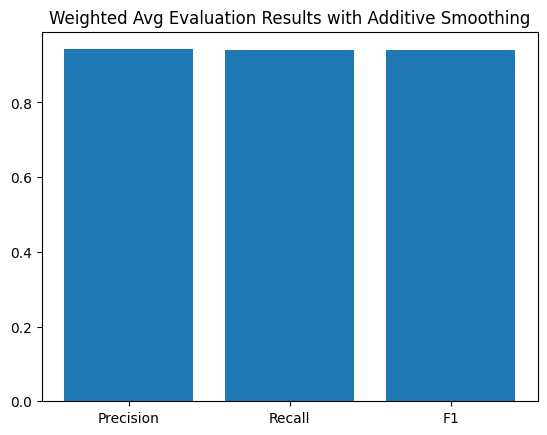

In [15]:
weighted_precision = 0; weighted_recall = 0; weighted_F1 = 0
for category in categories:
    weighted_precision += (class_count[category] * precisions[category])
    weighted_recall += (class_count[category] * recalls[category])
    weighted_F1 += (class_count[category] * F1s[category]) 
weighted_precision /= len(test_df)
weighted_recall /= len(test_df)
weighted_F1 /= len(test_df)
print("Weighted Average Precision: " + str(weighted_precision) + "%")
print("Weighted Average Recall: " + str(weighted_recall) + "%")
print("Weighted Average F1: " + str(weighted_F1) + "%")
fig, ax = plt.subplots()
ax.set_title("Weighted Avg Evaluation Results with Additive Smoothing")
words = ["Precision" , "Recall" , "F1"]
numbers = [weighted_precision , weighted_recall , weighted_F1]
ax.bar(words , numbers)
plt.show()

In [16]:
accuracy = str(AD_accuracy * 100)
print("Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = " + accuracy + "%")

Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = 94.08071748878923%


### $\color{deepskyblue}{\text{Question 11}}$ 
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
همانطور که می توان پیش بینی کرد Additive Smoothing بسیار نتایج مدل را بهتر خواهد کرد. بدون استفاده از آن به دلیل رویارویی با کلمات جدید در test بسیاری از اخبار دسته بندی نمی شوند و Recall بسیار کمی دارند اما معیار Precision مقدار نسبتا بالایی دارد که می توان نتیجه گرفت که فقط یکی از این معیار ها نمی تواند نتیجه درستی به ما دهد.
</font>
</p>

### $\color{deepskyblue}{\text{Question 12}}$ 
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
با توجه به اینکه به بافت جمله توجه نمی کنیم و کلمات را مستقل فرض می کنیم این اشکال وجود دارد. مثلا خبر مرگ یک ملی پوش دوچرخه سواری بسیار به اخبار های ورزشی نزدیک است و کلمات مشترک زیادی با این بخش دارد اما در بخش حوادث قرار گرفته است و با پرداختن به بافت جمله و مستقل فرض نکردن کلمات می توان این ایراد را رفع کرد.
</font>
</p>

In [17]:
counter, i = 0, 0
while True:
    i +=1
    if test_df.loc[i , "additive_smoothing_validity"] == False:
        print("\n")
        print(test_df.loc[i , "row_content"])
        print("Actual Category: " + test_df.loc[i , "label"])
        print("Predicted Category: " + test_df.loc[i , "additive_smoothing_results"])
        counter += 1
    if(counter == 5):
        break



- چهارشنبه اول تیر 1401 اتفاق نادر و جالبی رخ داد که قطعا به صورت تصادفی و بدون برنامه‌ریزی و اطلاع قبلی بوده است: این که به شکل کاملا هم‌زمان در محل انجمن صنفی روزنامه‌نگاران استان تهران از رونمایی شد و در صدا‌و‌سیما و در جمع معاونان سازمان هم از کلیات « ».   اگرچه سه واژۀ در هر دو مشترک‌اند اما هیچ ربط و شباهتی به هم ندارند. چرا که در اولی منظور از سند است و در دومی سند (در حالی که به تعبیر دکتر وب‌2 را هم پشت سر گذاشته و به زودی وارد وب‌3 خواهیم شد) و خود رادیو و تلویزیون دیگر رسانۀ مدرن نیست و به تعبیری رسانۀ تلویزیون در معنی عام و جهانی نه مشخصا صدا و سیما هر چند در ایران همچنان رایگان‌ترین و گسترده‌ترین امکان وقت‌گذرانی و ارتباطی است. (رایگان از جهت پرداخت حق اشتراک وگرنه بودجۀ آن از جیب ملت تأمین می‌شود). در اولی منظور از رسانه واقعا رسانه است. یعنی بدون بودجۀ حکومتی و مخاطب‌محور و در دومی به جز تعبیر «رسانه ملی» در باقی موارد ترجیح می‌دهند از مفاهیم ایدیولوژیک استفاده کنند و آن را در واقع عرصۀ جنگ می‌دانند یا با واژه های جنگ و قرارگاه حجم عظیم پرسنل و بودجه های کلان و انحصار 